# Train Bandits with per-arm features

**Exploring linear and nonlinear** (e.g., those with neural network-based value functions) bandit methods for recommendations using TF-Agents

> Neural linear bandits provide a nice way to leverage the representation power of deep learning and the bandit approach for uncertainty measure and efficient exploration

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
PREFIX = 'mabv1'

In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-hybrid-vertex-bucket/data"
BUCKET_URI               = "gs://mabv1-hybrid-vertex-bucket"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid-vertex.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "hybrid-vertex.movielens_dataset_mabv1.training_dataset"

REPO_DOCKER_PATH_PREFIX  = "src"
RL_SUB_DIR               = "per_arm_rl"



## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

from tqdm import tqdm

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
# from tf_agents.agents import TFAgent

# from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
# from tf_agents.drivers import dynamic_step_driver
# from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# from tf_agents.bandits.agents import lin_ucb_agent
# from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.policies import policy_utilities

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config
from src.per_arm_rl import train_utils as train_utils

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [5]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
# gpus

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
device = cuda.get_current_device()
device.reset()
gc.collect()

22

In [7]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Read TF Records

In [8]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [9]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-hybrid-vertex-bucket/data/train/ml-ratings-100k-train.tfrecord']

In [10]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


### get vocab

**TODO:** 
* streamline vocab calls

In [11]:
GENERATE_VOCABS = False
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

VOCAB_SUBDIR   = "vocabs"
VOCAB_FILENAME = "vocab_dict.pkl"

GENERATE_VOCABS: False


In [12]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


## helper functions

**TODO:**
* modularize in a train_utils or similar

# Multi-Armed Bandits (MAB) with Per-Arm Features

In [13]:
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer

nest = tf.nest

# [1] Preprocessing layers for global and arm features

The preproccesing layers will ultimately feed the two sampling functions described below. These sampling functions will be used to create [trajectories](https://github.com/tensorflow/agents/blob/master/tf_agents/trajectories/trajectory.py#L36) (i.e., the training examples for our model)

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). * This output is the per-arm context. Its shape must be consistent across calls.

In [14]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 16
MV_EMBEDDING_SIZE      = 32 #32

## global context (user) features

#### user ID

In [15]:
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)

user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)

user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

# global_inputs.append(user_id_input_layer)
# global_features.append(user_id_embedding)

In [16]:
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

# for x in train_dataset.batch(1).take(1):
#     print(x["user_id"])
#     print(test_user_id_model(x["user_id"]))

#### user AGE

In [17]:
user_age_input_layer = tf.keras.Input(
    name="bucketized_user_age",
    shape=(1,),
    dtype=tf.float32
)

user_age_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['bucketized_user_age'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(user_age_input_layer)

user_age_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['bucketized_user_age']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_age_lookup)

user_age_embedding = tf.reduce_sum(user_age_embedding, axis=-2)

# global_inputs.append(user_age_input_layer)
# global_features.append(user_age_embedding)

In [18]:
test_user_age_model = tf.keras.Model(inputs=user_age_input_layer, outputs=user_age_embedding)

# for x in train_dataset.batch(1).take(1):
#     print(x["bucketized_user_age"])
#     print(test_user_age_model(x["bucketized_user_age"]))

#### user OCC

In [19]:
user_occ_input_layer = tf.keras.Input(
    name="user_occupation_text",
    shape=(1,),
    dtype=tf.string
)

user_occ_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_occupation_text'],
)(user_occ_input_layer)

user_occ_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_occ_lookup)

user_occ_embedding = tf.reduce_sum(user_occ_embedding, axis=-2)

# global_inputs.append(user_occ_input_layer)
# global_features.append(user_occ_embedding)

In [20]:
test_user_occ_model = tf.keras.Model(inputs=user_occ_input_layer, outputs=user_occ_embedding)

# for x in train_dataset.batch(1).take(1):
#     print(x["user_occupation_text"])
#     print(test_user_occ_model(x["user_occupation_text"]))

#### user Timestamp

In [21]:
user_ts_input_layer = tf.keras.Input(
    name="timestamp",
    shape=(1,),
    dtype=tf.int64
)

user_ts_lookup = tf.keras.layers.Discretization(
    vocab_dict['timestamp_buckets'].tolist()
)(user_ts_input_layer)

user_ts_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['timestamp_buckets'].tolist()) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_ts_lookup)

user_ts_embedding = tf.reduce_sum(user_ts_embedding, axis=-2)

# global_inputs.append(user_ts_input_layer)
# global_features.append(user_ts_embedding)

In [22]:
test_user_ts_model = tf.keras.Model(inputs=user_ts_input_layer, outputs=user_ts_embedding)

# for x in train_dataset.batch(1).take(1):
#     print(x["timestamp"])
#     print(test_user_ts_model(x["timestamp"]))

### define global sampling function

In [23]:
def _get_global_context_features(x):
    """
    This function generates a single global observation vector.
    """
    user_id_value = x['user_id']
    user_age_value = x['bucketized_user_age']
    user_occ_value = x['user_occupation_text']
    user_ts_value = x['timestamp']

    _id = test_user_id_model(user_id_value) # input_tensor=tf.Tensor(shape=(4,), dtype=float32)
    _age = test_user_age_model(user_age_value)
    _occ = test_user_occ_model(user_occ_value)
    _ts = test_user_ts_model(user_ts_value)

    # # tmp - insepct numpy() values
    # print(_id.numpy()) #[0])
    # print(_age.numpy()) #[0])
    # print(_occ.numpy()) #[0])
    # print(_ts.numpy()) #[0])

    # to numpy array
    _id = np.array(_id.numpy())
    _age = np.array(_age.numpy())
    _occ = np.array(_occ.numpy())
    _ts = np.array(_ts.numpy())

    concat = np.concatenate(
        [_id, _age, _occ, _ts], axis=-1 # -1
    ).astype(np.float32)

    return concat

In [188]:
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

data

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}

In [25]:
GLOBAL_DIM = _get_global_context_features(data).shape[1]
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

GLOBAL_DIM: 64


## arm preprocessing layers

#### movie ID

In [26]:
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)

mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)

mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)

mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

# arm_inputs.append(mv_id_input_layer)
# arm_features.append(mv_id_embedding)

In [27]:
test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

# for x in train_dataset.batch(1).take(1):
#     print(x["movie_id"])
#     print(test_mv_id_model(x["movie_id"]))

#### movie genre

In [28]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

# arm_inputs.append(mv_genre_input_layer)
# arm_features.append(mv_genre_embedding)

In [29]:
test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

# for x in train_dataset.batch(1).take(1):
#     print(x["movie_genres"])
#     print(test_mv_gen_model(x["movie_genres"]))

### define sampling function

In [30]:
def _get_per_arm_features(x):
    """
    This function generates a single per-arm observation vector
    """
    mv_id_value = x['movie_id']
    mv_gen_value = x['movie_genres']

    _mid = test_mv_id_model(mv_id_value)
    _mgen = test_mv_gen_model(mv_gen_value)

    # to numpy array
    _mid = np.array(_mid.numpy())
    _mgen = np.array(_mgen.numpy())

    # print(_mid)
    # print(_mgen)

    concat = np.concatenate(
        [_mid, _mgen], axis=-1 # -1
    ).astype(np.float32)
    # concat = tf.concat([_mid, _mgen], axis=-1).astype(np.float32)

    return concat #this is special to this example - there is only one action dimensions

In [31]:
PER_ARM_DIM = _get_per_arm_features(data).shape[1] #shape checks out at batchdim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

PER_ARM_DIM: 64


# [2] Implementing MAB with TF-Agents

In TF-Agents, the *per-arm features* implementation differs from the *global-only* feature examples in the following aspects:
* Reward is modeled not per-arm, but globally.
* The arms are permutation invariant: it doesn’t matter which arm is arm 1 or arm 2, only their features.
* One can have a different number of arms to choose from in every step (note that unspecified/dynamically changing number of arms will have a problem with XLA compatibility).

When implementing per-arm features in TF-Bandits, the following details have to be discussed:
* Observation spec and observations,
* Action spec and actions,
* Implementation of specific policies and agents.


**TODO:**
* outline the components and highlight their interactions, dependencies on eachother, etc.

In [32]:
BATCH_SIZE      = 128
EVAL_BATCH_SIZE = 1

NUM_ACTIONS     = 2 #this is kinda deceptive - 
#our approach is to learn by "flashing" one movie rating at a time per user context. 
#The n_actions = show/don't show the movie with one degree of freedom (n-1)


print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")
print(f"GLOBAL_DIM      : {GLOBAL_DIM}")
print(f"PER_ARM_DIM     : {PER_ARM_DIM}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2
GLOBAL_DIM      : 64
PER_ARM_DIM     : 64


## Tensor Specs

* say you have a global observation spec of `[17]`. And you have two batch dimensions `[4, 5]`. Then your observation has to have the shape `[4, 5, 17]`
* and then if you have arm_obs_spec with shape `[9, 13]`, then the arm obs shape has to be exactly `[4, 5, 9, 13]`
* and this has to be true for every single tensor in your tensor nest
* the first 2 dims are the outer dims that are the same for all tensors, the rest of the dimensions have to follow the spec for each tensor

**TODO:**
* explain relationship between Tensor Specs and their Tensor counterparts
* highlight the errors, lessons learned, and utility functions to address these

### Observation spec

**This observation spec allows the user to have a global observation of fixed dimension**, and an unspecified number of *per-arm* features (also of fixed dimension)
* The actions output by the policy are still integers as usual, and they indicate which row of the arm-features it has chosen 
* The action spec must be a single integer value without boundaries:

```python
global_spec = tensor_spec.TensorSpec([GLOBAL_DIM], tf.float32)
per_arm_spec = tensor_spec.TensorSpec([None, PER_ARM_DIM], tf.float32)
observation_spec = {'global': global_spec, 'per_arm': per_arm_spec}

action_spec = tensor_spec.TensorSpec((), tf.int32)
```
> Here the only difference compared to the action spec with global features only is that the tensor spec is not bounded, as we don’t know how many arms there will be at any time step

**XLA compatibility:**
* Since dynamic tensor shapes are not compatible with XLA, the number of arm features (and consequently, number of arms for a step) cannot be dynamic. 
* One workaround is to fix the maximum number of arms for a problem, then pad the arm features in steps with fewer arms, and use action masking to indicate how many arms are actually active.

```python
per_arm_spec = tensor_spec.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32)

action_spec = tensor_spec.BoundedTensorSpec(
    shape=(), dtype=tf.int32, minimum = 0, maximum = NUM_ACTIONS - 1
)
```

In [33]:
# # TF-Agents has many helper and utility functions
# observation_spec = bandit_spec_utils.create_per_arm_observation_spec(
#     GLOBAL_DIM, PER_ARM_DIM, NUM_ACTIONS, 
#     add_num_actions_feature=False
# ) # 2,3,4

observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_ACTIONS, PER_ARM_DIM], tf.float32) #excluding action dim here
}
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

### Action spec

> The time_step_spec and action_spec are specifications for the input time step and the output action

```python
    if (
        not tensor_spec.is_bounded(action_spec)
        or not tensor_spec.is_discrete(action_spec)
        or action_spec.shape.rank > 1
        or action_spec.shape.num_elements() != 1
    ):
      raise NotImplementedError(
          'action_spec must be a BoundedTensorSpec of type int32 and shape (). '
          'Found {}.'.format(action_spec)
      )
```

* [src](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L97)

In [34]:
action_spec = tensor_spec.BoundedTensorSpec(
    shape=[], 
    dtype=tf.int32,
    minimum=tf.constant(0),            
    maximum=NUM_ACTIONS-1, # n degrees of freedom and will dictate the expected mean reward spec shape
    name="action_spec"
)

action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

In [35]:
expected_num_actions = action_spec.maximum - action_spec.minimum + 1
print(f"expected_num_actions: {expected_num_actions}")

predicted_rewards_mean = tensor_spec.TensorSpec([expected_num_actions])
print(f"predicted_rewards_mean: {predicted_rewards_mean}")

expected_num_actions: 2
predicted_rewards_mean: TensorSpec(shape=(2,), dtype=tf.float32, name=None)


### TimeStep spec

In [36]:
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    # reward_spec = _reward_spec
)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

#### Inspect chosen arm features spec

In [37]:
time_step_spec.observation

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [38]:
chosen_arm_features_info = (
  policy_utilities.create_chosen_arm_features_info_spec(
      time_step_spec.observation,
  )
)
chosen_arm_features_info

TensorSpec(shape=(64,), dtype=tf.float32, name=None)

In [39]:
# TODO - dont understand this
bandit_policy_type = (
    policy_utilities.BanditPolicyType.GREEDY
)
bandit_policy_type

1

In [40]:
# TODO - dont understand this
bandit_policy_type = (
    policy_utilities.create_bandit_policy_type_tensor_spec(shape=[1])
)
bandit_policy_type

BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))

In [41]:
info_spec = policy_utilities.PerArmPolicyInfo(
  predicted_rewards_mean=predicted_rewards_mean,
  bandit_policy_type=bandit_policy_type,
  chosen_arm_features=chosen_arm_features_info,
)
info_spec

PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None))

## The Agent

**Note** that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment 

> “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation)

### Agent & Network defined

#### **Agent types**

> `AGENT_TYPE = ['LinUCB', 'LinTS', 'epsGreedy', 'NeuralLinUCB']`

LinearUCBAgent: (`LinUCB`) 
* An agent implementing the Linear UCB bandit algorithm ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent/LinearUCBAgent))

LinearThompsonSamplingAgent: (`LinTS`) 
* Implements the Linear Thompson Sampling Agent from the [paper](https://arxiv.org/abs/1209.3352): *Thompson Sampling for Contextual Bandits with Linear Payoffs* ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/linear_thompson_sampling_agent/LinearThompsonSamplingAgent))

NeuralEpsilonGreedyAgent: (`epsGreedy`) 
* A neural network based epsilon greedy agent ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_epsilon_greedy_agent/NeuralEpsilonGreedyAgent))

NeuralLinUCBAgent: (`NeuralLinUCB`) 
* An agent implementing the LinUCB algorithm on top of a neural network ([docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/neural_linucb_agent/NeuralLinUCBAgent))

#### **Network types**

Which network architecture to use for the `epsGreedy` or `NeuralLinUCB` agents

```
NETWORK_TYPE = ['commontower', 'dotproduct']
```

**GlobalAndArmCommonTowerNetwork:** (`commontower`)
* This network takes the output of the global and per-arm networks, and leads them through a common network, that in turn outputs reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
> * `COMMON_LAYERS` - Iterable of ints. Specifies the layers of the common tower
* The network produced by this function can be used either in `GreedyRewardPredictionPolicy`, or `NeuralLinUCBPolicy`
> * In the former case, the network must have `output_dim=1`, it is going to be an instance of `QNetwork`, and used in the policy as a reward prediction network
> * In the latter case, the network will be an encoding network with its output consumed by a reward layer or a `LinUCB` method. The specified `output_dim` will be the encoding dimension
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmCommonTowerNetwork)

**GlobalAndArmDotProductNetwork:** (`dotproduct`)
* This network calculates the **dot product** of the output of the global and per-arm networks and returns them as reward estimates
> * `GLOBAL_LAYERS` - Iterable of ints. Specifies the layers of the global tower
> * `ARM_LAYERS` - Iterable of ints. Specifies the layers of the arm tower
* [docs](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/networks/global_and_arm_feature_network/GlobalAndArmDotProductNetwork)

### Agent config

In [42]:
print("Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs")
print("\ntime_step_spec: ", time_step_spec)
print("\naction_spec: ", action_spec)
print("\nobservation_spec: ", observation_spec)

Quick check on the inputs of the agent - this can be used to diagnose spec shape inputs

time_step_spec:  TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

action_spec:  BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

observation_spec:  {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}


In [66]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'epsGreedy' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
NETWORK_TYPE    = "commontower" # 'commontower' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    
GLOBAL_LAYERS   = [64, 32, 16]
ARM_LAYERS      = [64, 32, 16]
COMMON_LAYERS   = [16, 8]

HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [16, 8],
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [64, 32, 16],
 'learning_rate': 0.05,
 'model_type': 'epsGreedy',
 'network_type': 'commontower',
 'num_actions': 2,
 'per_arm_layers': [64, 32, 16]}


In [44]:
# # from tf_agents.bandits.policies import policy_utilities
# # from tf_agents.bandits.agents import greedy_reward_prediction_agent

# def _get_agent(
#     agent_type, 
#     network_type, 
#     time_step_spec, 
#     action_spec, 
#     observation_spec,
#     global_step
# ):
#     network = None
#     observation_and_action_constraint_splitter = None

#     if AGENT_TYPE == 'LinUCB':
#         agent = lin_ucb_agent.LinearUCBAgent(
#             time_step_spec=time_step_spec,
#             action_spec=action_spec,
#             alpha=AGENT_ALPHA,
#             accepts_per_arm_features=True,
#             dtype=tf.float32,
#         )
#     elif AGENT_TYPE == 'LinTS':
#         agent = lin_ts_agent.LinearThompsonSamplingAgent(
#             time_step_spec=time_step_spec,
#             action_spec=action_spec,
#             alpha=AGENT_ALPHA,
#             observation_and_action_constraint_splitter=(
#                 observation_and_action_constraint_splitter
#             ),
#             accepts_per_arm_features=True,
#             dtype=tf.float32,
#         )
#     elif AGENT_TYPE == 'epsGreedy':
#         # obs_spec = per_arm_tf_env.observation_spec()
#         if NETWORK_TYPE == 'commontower':
#             network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
#                 observation_spec = observation_spec, 
#                 global_layers = GLOBAL_LAYERS, 
#                 arm_layers = ARM_LAYERS, 
#                 common_layers = COMMON_LAYERS,
#                 output_dim = 1
#             )
#         elif NETWORK_TYPE == 'dotproduct':
#             network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
#                 observation_spec = observation_spec, 
#                 global_layers = GLOBAL_LAYERS, 
#                 arm_layers = ARM_LAYERS
#             )
#         agent = neural_epsilon_greedy_agent.NeuralEpsilonGreedyAgent(
#             time_step_spec=time_step_spec,
#             action_spec=action_spec,
#             reward_network=network,
#             optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
#             epsilon=HPARAMS['epsilon'],
#             observation_and_action_constraint_splitter=(
#                 observation_and_action_constraint_splitter
#             ),
#             accepts_per_arm_features=True,
#             emit_policy_info=(
#                 policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
#                 policy_utilities.BanditPolicyType.GREEDY,
#             ),
#             train_step_counter=global_step,
#             # info_fields_to_inherit_from_greedy=[
#             #     policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN
#             # ],
#             name='OffpolicyNeuralEpsGreedyAgent'
#         )

#     elif AGENT_TYPE == 'NeuralLinUCB':
#         # obs_spec = per_arm_tf_env.observation_spec()
#         network = (
#             global_and_arm_feature_network.create_feed_forward_common_tower_network(
#                 observation_spec = observation_spec, 
#                 global_layers = GLOBAL_LAYERS, 
#                 arm_layers = ARM_LAYERS, 
#                 common_layers = COMMON_LAYERS,
#                 output_dim = ENCODING_DIM
#             )
#         )
#         agent = neural_linucb_agent.NeuralLinUCBAgent(
#             time_step_spec=per_arm_tf_env.time_step_spec(),
#             action_spec=per_arm_tf_env.action_spec(),
#             encoding_network=network,
#             encoding_network_num_train_steps=EPS_PHASE_STEPS,
#             encoding_dim=ENCODING_DIM,
#             optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
#             alpha=1.0,
#             gamma=1.0,
#             epsilon_greedy=EPSILON,
#             accepts_per_arm_features=True,
#             debug_summaries=True,
#             summarize_grads_and_vars=True,
#             emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
#         )
        
#     print(f"Agent   : {agent.name}")

#     if network:
#         print(f"Network : {network.name}")
#         network = network.name
    
#     return agent, network

In [45]:
# global_step = tf.compat.v1.train.get_or_create_global_step()

# agent, network = _get_agent(
#     agent_type = AGENT_TYPE, 
#     network_type = NETWORK_TYPE, 
#     time_step_spec = time_step_spec, 
#     action_spec = action_spec, 
#     observation_spec = observation_spec,
#     global_step = global_step
# )

# agent.initialize() # TODO - does this go here?

# agent.policy.trajectory_spec

Agent   : OffpolicyNeuralEpsGreedyAgent
Network : global_and_arm_common_tower_network


_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action_spec', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(2,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.i

In [47]:
from src.perarm_features import agent_factory as agent_factory

global_step = tf.compat.v1.train.get_or_create_global_step()

agent, network = agent_factory._get_agent(
    agent_type=AGENT_TYPE, 
    network_type=NETWORK_TYPE, 
    time_step_spec=time_step_spec, 
    action_spec=action_spec, 
    observation_spec=observation_spec,
    global_step = global_step,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    encoding_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
)

print(f"Agent: {agent.name}")

if network:
    print(f"Network: {network}")
        
agent.initialize()

In [46]:
agent.name

'OffpolicyNeuralEpsGreedyAgent'

## Reward function

**TODO:**
* explain how to translate reward to this common recommendation objectives

In [47]:
def _get_rewards(element):
    """Calculates reward for the actions."""

    def _calc_reward(x):
        """Calculates reward for a single action."""
        r0 = lambda: tf.constant(0.0)
        r1 = lambda: tf.constant(1.0)
        r2 = lambda: tf.constant(2.0)
        r3 = lambda: tf.constant(3.0)
        r4 = lambda: tf.constant(4.0)
        r5 = lambda: tf.constant(5.0)
        c1 = tf.equal(x, 1.0)
        c2 = tf.equal(x, 2.0)
        c3 = tf.equal(x, 3.0)
        c4 = tf.equal(x, 4.0)
        c5 = tf.equal(x, 5.0)
        return tf.case(
            [(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], 
            default=r0, exclusive=True
        )

    return tf.map_fn(
        fn=_calc_reward, 
        elems=element['user_rating'], 
        dtype=tf.float32
    )

## Trajectory function

**parking lot**
* does trajectory fn need concept of `dummy_chosen_arm_features`, similar to [this](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/policies/reward_prediction_base_policy.py#L297)

```python
      dummy_chosen_arm_features = tf.nest.map_structure(
          lambda obs: tf.zeros_like(obs[:, 0, ...]),
          time_step.observation[bandit_spec_utils.PER_ARM_FEATURE_KEY],
      )
```

In [49]:
# from tf_agents.bandits.specs import utils as bandit_spec_utils
# from tf_agents.trajectories import trajectory
# from src.per_arm_rl import train_utils_v2 as train_utils

In [48]:
def _trajectory_fn(element): # hparams
    
    """Converts a dataset element into a trajectory."""
    global_features = _get_global_context_features(element)
    arm_features = _get_per_arm_features(element)
    
    # Adds a time dimension.
    arm_features = train_utils._add_outer_dimension(arm_features)

    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            train_utils._add_outer_dimension(global_features),
    }

    reward = train_utils._add_outer_dimension(_get_rewards(element))

    # To emit the predicted rewards in policy_info, we need to create dummy
    # rewards to match the definition in TensorSpec for the ones specified in
    # emit_policy_info set.
    dummy_rewards = tf.zeros([HPARAMS['batch_size'], 1, HPARAMS['num_actions']])
    policy_info = policy_utilities.PerArmPolicyInfo(
        chosen_arm_features=arm_features,
        # Pass dummy mean rewards here to match the model_spec for emitting
        # mean rewards in policy info
        predicted_rewards_mean=dummy_rewards,
        bandit_policy_type=policy_utilities.BanditPolicyType.GREEDY
    )
    
    if HPARAMS['model_type'] == 'neural_ucb':
        policy_info = policy_info._replace(
            predicted_rewards_optimistic=dummy_rewards
        )
        
    return trajectory.single_step(
        observation=observation,
        action=tf.zeros_like(
            reward, dtype=tf.int32
        ),  # Arm features are copied from policy info, put dummy zeros here
        policy_info=policy_info,
        reward=reward,
        discount=tf.zeros_like(reward)
    )

In [51]:
# TRAJECTORY_SUBDIR = "trajectories"
# os.mkdir(f'{TRAJECTORY_SUBDIR}')

In [52]:
# LOCAL_FILENAME = f"trajectories_{HPARAMS['batch_size']}"

# print(LOCAL_FILENAME)

In [53]:
# for x in train_dataset.batch(HPARAMS['batch_size']).take(1):
#     test_traj = _trajectory_fn(x)
    
# test_traj

In [54]:
# tf.rank(test_traj.observation['global'])

In [55]:
# tf.rank(test_traj.reward)

# [3] Training the agent

### calculate train dataset size

In [49]:
# TRAIN_DATA_SIZE = len(list(train_dataset))
TRAIN_DATA_SIZE = 80000

NUM_TRAIN_STEPS = TRAIN_DATA_SIZE // HPARAMS['batch_size']
# NUM_TRAIN_STEPS = 10000

print(f"TRAIN_DATA_SIZE : {TRAIN_DATA_SIZE}")
print(f"NUM_TRAIN_STEPS : {NUM_TRAIN_STEPS}")

TRAIN_DATA_SIZE : 80000
NUM_TRAIN_STEPS : 625


### create eval dataset

In [50]:
SPLIT = "val"

val_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
val_dataset = tf.data.TFRecordDataset(val_files)
val_dataset = val_dataset.map(data_utils.parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

## set Vertex Experiment

In [53]:
EXPERIMENT_NAME   = f'mab-local-v6'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : mab-local-v6
RUN_NAME          : run-20230821-222258

BASE_OUTPUT_DIR   : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-222258
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-222258/logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-222258/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-222258/artifacts


## eval loop

In [54]:
# ====================================================
# eval loop
# ====================================================

def _run_bandit_eval(
    policy,
    data,
    eval_batch_size,
    per_arm_dim,
    global_dim,
):
    logged_rewards = []
    predicted_rewards = []
    trouble_list = []
    train_loss_results = []
    
    dummy_arm = tf.zeros([eval_batch_size, per_arm_dim], dtype=tf.float32)

    for x in data:
        # get feature tensors
        global_feat_infer = _get_global_context_features(x)
        arm_feat_infer = _get_per_arm_features(x)
        rewards = _get_rewards(x)

        # reshape arm features
        arm_feat_infer = tf.reshape(arm_feat_infer, [eval_batch_size, per_arm_dim])
        concat_arm = tf.concat([arm_feat_infer, dummy_arm], axis=0)

        # flatten global
        flat_global_infer = tf.reshape(global_feat_infer, [global_dim])
        feature = {'global': flat_global_infer, 'per_arm': concat_arm}

        # get actual reward
        actual_reward = rewards.numpy()[0]
        # logged_rewards.append(actual_reward)

        # build trajectory step
        trajectory_step = train_utils._get_eval_step(feature, actual_reward)
        
        # pred w/ trained agent
        prediction = policy.action(trajectory_step)
        # prediction = trained_policy.action(trajectory_step)
        # prediction_list.append(prediction)

        predicted_rewards_mean = prediction.info.predicted_rewards_mean #[0]
        # pred_rewards_mean_list.append(predicted_rewards_mean)
        
        predicted_reward_tf = tf.gather(
            predicted_rewards_mean,
            prediction.action, 
            batch_dims=0, 
            axis=-1
        )

        pred_reward = float(round(predicted_reward_tf.numpy()))

        # When the uniform random policy is used, the 
        #    loss is meaningless for evaluation
        # > discard preds from uniform random policy
        # > keep preds from greedy policy, 
        if pred_reward < 0:
            trouble_list.append(pred_reward)
        elif pred_reward > 5:
            trouble_list.append(pred_reward)
        else:
            predicted_rewards.append(pred_reward)

            pred_loss = tf.keras.metrics.mean_squared_error(
                rewards, predicted_reward_tf
            )
            train_loss_results.append(pred_loss)
            logged_rewards.append(actual_reward)
            
    # calculate avg loss
    avg_eval_loss = tf.reduce_mean(train_loss_results)
    
    return (
        avg_eval_loss,
        predicted_rewards,
        logged_rewards,
        # train_loss_results
    )

## train loop

In [55]:
import collections

from tf_agents.policies import py_tf_eager_policy
from tf_agents.trajectories import time_step as ts
from tf_agents.policies import policy_saver
from tf_agents.metrics import export_utils
from tf_agents.metrics import tf_metrics
from tf_agents.eval import metric_utils
from tf_agents.utils import common

# from src.per_arm_rl import train_utils

`agent.train(experience=...)`

where `experience` is a batch of trajectories data in the form of a Trajectory. 
* The structure of experience must match that of `self.training_data_spec`. 
* All tensors in experience must be shaped [batch, time, ...] where time must be equal to self.train_step_length if that property is not None.

### logs & checkpoints

In [56]:
# ====================================================
# TB summary writer
# ====================================================
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    f"{LOG_DIR}/train", flush_millis=10 * 1000
)
# train_summary_writer.set_as_default()

# eval_summary_writer = tf.compat.v2.summary.create_file_writer(
#     f"{LOG_DIR}/eval", flush_millis=10 * 1000
# )
# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()
metrics = [
    # tf_metrics.NumberOfEpisodes(),
    # tf_metrics.AverageEpisodeLengthMetric(batch_size=HPARAMS['batch_size']),
    tf_metrics.AverageReturnMetric(batch_size=HPARAMS['batch_size'])
]

pprint(f"metrics: {metrics}")

# ====================================================
# get checkpoint manager
# ====================================================
CHKPOINT_DIR = f"{ROOT_DIR}/chkpoint"
print(f"setting checkpoint_manager: {CHKPOINT_DIR}")

checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHKPOINT_DIR, 
    agent=agent, 
    metrics=metrics, 
    step_metric=step_metric
)
# ====================================================
# policy saver
# ====================================================
saver = policy_saver.PolicySaver(
    agent.policy, 
    train_step=global_step
)

('metrics: [<tf_agents.metrics.tf_metrics.NumberOfEpisodes object at '
 '0x7f89dc288070>, <tf_agents.metrics.tf_metrics.AverageEpisodeLengthMetric '
 'object at 0x7f89dc289e10>, <tf_agents.metrics.tf_metrics.AverageReturnMetric '
 'object at 0x7f89dc28ba00>]')
setting checkpoint_manager: gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-222258/root/chkpoint


### evaluate policy loop

In [57]:
# TRAIN_DATA_SIZE = len(list(train_dataset))
TRAIN_DATA_SIZE = 80000

NUM_TRAIN_STEPS = TRAIN_DATA_SIZE // HPARAMS['batch_size']
# NUM_TRAIN_STEPS = 10000

print(f"TRAIN_DATA_SIZE : {TRAIN_DATA_SIZE}")
print(f"NUM_TRAIN_STEPS : {NUM_TRAIN_STEPS}")

TRAIN_DATA_SIZE : 80000
NUM_TRAIN_STEPS : 625


In [58]:
# EVAL_DATA_SIZE = len(list(val_dataset))
EVAL_DATA_SIZE = 20000

# NUM_EVAL_STEPS = EVAL_DATA_SIZE // HPARAMS['eval_batch_size']
NUM_EVAL_STEPS = 10000

print(f"EVAL_DATA_SIZE : {EVAL_DATA_SIZE}")
print(f"NUM_EVAL_STEPS : {NUM_EVAL_STEPS}")

EVAL_DATA_SIZE : 20000
NUM_EVAL_STEPS : 10000


In [59]:
# eval dataset
eval_ds = val_dataset.batch(HPARAMS["eval_batch_size"])

if NUM_EVAL_STEPS > 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)
# eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

# NUM_ITER_STEPS = 200
NUM_ITER_STEPS = NUM_TRAIN_STEPS #* 2
print(f"NUM_ITER_STEPS: {NUM_ITER_STEPS}")

# CHKPT_INTERVAL = NUM_ITER_STEPS // 5
CHKPT_INTERVAL = NUM_TRAIN_STEPS
print(f"CHKPT_INTERVAL: {CHKPT_INTERVAL}")

log_interval = 50
print(f"log_interval : {log_interval}")

# eval_interval = log_interval #* 2
eval_interval = NUM_ITER_STEPS // 2
print(f"eval_interval : {eval_interval}")

NUM_ITER_STEPS: 625
CHKPT_INTERVAL: 625
log_interval : 50
eval_interval : 312


### run train loop

In [65]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
# agent.train = common.function(agent.train)
# train_step_counter = tf.compat.v1.train.get_or_create_global_step()
# train_loss = collections.defaultdict(list)

list_o_loss = []
# list_o_vloss = []

# dummy_arm = tf.zeros([HPARAMS['eval_batch_size'], PER_ARM_DIM], dtype=tf.float32)
# ====================================================
# dataset iterators
# ====================================================
train_ds_iterator = iter(train_dataset.batch(HPARAMS['batch_size']).repeat(5))
# eval_ds_iterator = iter(eval_ds)

# ====================================================
# Evaluate the agent's policy once before training
# ====================================================
# Reset the train step
agent.train_step_counter.assign(0)

pre_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)

print(f"evaluating pre-trained Agent...")
start_time = time.time()

pre_val_loss, pre_preds, pre_tr_rewards = _run_bandit_eval(
    policy = pre_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"pre-train val_loss     : {pre_val_loss}")
print(f"pre-train eval runtime : {runtime_mins}")
# ====================================================
# train loop
# ====================================================
print(f"starting train loop...")
start_time = time.time()

# for i in tqdm(range(NUM_ITER_STEPS)):
for i in range(NUM_ITER_STEPS):
    
    with train_summary_writer.as_default():

        data = next(train_ds_iterator)
        trajectories = _trajectory_fn(data)

        # All tensors in experience must be shaped [batch, time, ...] 
        step = agent.train_step_counter.numpy()
        loss = agent.train(experience=trajectories)
        list_o_loss.append(loss.loss.numpy())

        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=metrics
        )

        # print step loss
        if step % log_interval == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )

        if i > 0 and i % CHKPT_INTERVAL == 0:
            saver.save(os.path.join(CHKPOINT_DIR, 'policy_%d' % step_metric.result()))
            print(f"saved policy to: {CHKPOINT_DIR}")
   
runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

saver.save(ARTIFACTS_DIR)
print(f"saved trained policy to: {ARTIFACTS_DIR}")

# ====================================================
# Evaluate the agent's policy once after training
# ====================================================
print(f"evaluating trained Agent...")

post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)
start_time = time.time()

val_loss, preds, tr_rewards = _run_bandit_eval(
    policy = post_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"post-train val_loss     : {val_loss}")
print(f"post-train eval runtime : {runtime_mins}")

evaluating pre-trained Agent...
pre-train val_loss     : 15.119401931762695
pre-train eval runtime : 4
starting train loop...
step = 0: train loss = 15.90999984741211
step = 50: train loss = 1.2799999713897705
step = 100: train loss = 1.5299999713897705
step = 150: train loss = 1.350000023841858
step = 200: train loss = 1.2300000190734863
step = 250: train loss = 1.2699999809265137
step = 300: train loss = 0.9700000286102295
step = 350: train loss = 1.2400000095367432
step = 400: train loss = 1.1699999570846558
step = 450: train loss = 1.350000023841858
step = 500: train loss = 1.2899999618530273
step = 550: train loss = 1.2400000095367432
step = 600: train loss = 1.2300000190734863
train runtime_mins: 6
saved trained policy to: gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-205512/artifacts
evaluating trained Agent...
post-train val_loss     : 1.1103360652923584
post-train eval runtime : 4


In [66]:
val_loss.numpy()

1.1103361

## Evaluate train job

### train loss

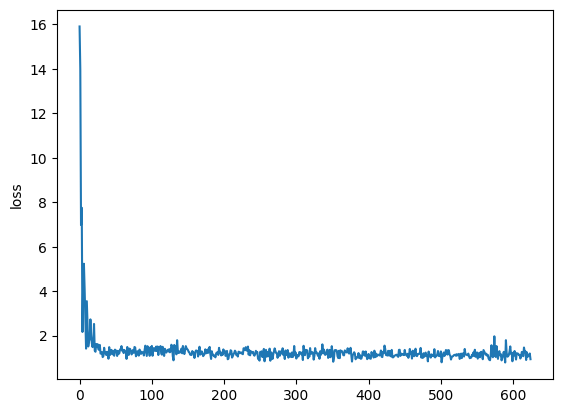

In [67]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

### TensorBoard

In [78]:
%load_ext tensorboard
# %reload_ext tensorboard

In [79]:
%tensorboard --logdir=$LOG_DIR

# [4] Inference

## load trained policy

In [68]:
POLICY_URI = ARTIFACTS_DIR
# "gs://mabv1-hybrid-vertex-bucket/mab-local-v4/run-20230817-142118/artifacts"
# "gs://mabv1-hybrid-vertex-bucket/mab-local-v4/run-20230817-193342/artifacts"
# "gs://mabv1-hybrid-vertex-bucket/mab-local-v4/run-20230817-211040/artifacts"
print(POLICY_URI)

gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-205512/artifacts


In [69]:
from tf_agents.policies import py_tf_eager_policy

trained_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    POLICY_URI, load_specs_from_pbtxt=True
)
trained_policy

## get predictions

In [70]:
eval_ds

<_TakeDataset element_spec={'bucketized_user_age': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_occupation_text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

In [71]:
INFER_SIZE = 1
dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

for x in eval_ds.take(INFER_SIZE):
    # get feature tensors
    global_feat_infer = _get_global_context_features(x)
    arm_feat_infer = _get_per_arm_features(x)
    rewards = _get_rewards(x)
    
    # reshape arm features
    arm_feat_infer = tf.reshape(arm_feat_infer, [HPARAMS['eval_batch_size'], PER_ARM_DIM]) # perarm_dim
    concat_arm = tf.concat([arm_feat_infer, dummy_arm], axis=0)
    
    # flatten global
    flat_global_infer = tf.reshape(global_feat_infer, [GLOBAL_DIM])
    feature = {'global': flat_global_infer, 'per_arm': concat_arm}
    
    # get actual reward
    actual_reward = rewards.numpy()[0]
    
    # build trajectory step
    trajectory_step = train_utils._get_eval_step(feature, actual_reward)
    
    prediction = trained_policy.action(trajectory_step)

In [72]:
prediction

PolicyStep(action=array(0, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.5728416, 3.0374527], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=array([ 1.5639726e-02, -3.1821765e-02, -7.5147375e-03, -1.2750387e-02,
        4.9963664e-02, -3.3286057e-02,  2.0584855e-02,  4.2843375e-02,
        4.7787178e-02,  4.5679066e-02,  3.7793424e-02, -2.6883258e-02,
       -3.4554709e-02, -4.9798973e-03,  6.9301240e-03,  1.8555392e-02,
       -4.2709459e-02, -3.8219713e-02,  4.1822616e-02,  4.2918887e-02,
       -2.9764270e-02, -4.5768548e-02,  2.8009426e-02, -4.6644323e-03,
        4.1721944e-02,  3.5448086e-02,  4.0199231e-02,  3.8426746e-02,
       -7.5555667e-03, -2.7164925e-02, -2.0989180e-03, -4.8757769e-02,
        4.6904575e-02,  9.7514614e-03,  3.5535041e-02, -4.1110791e-02,
        1.9986000e-02, -4.6567429e-02, -

In [73]:
prediction.info.bandit_policy_type

()

## get eval on validation set

### prepare eval dataset iter

In [74]:
EVAL_BATCH_SIZE = HPARAMS['eval_batch_size']

# NUM_EVAL_STEPS = EVAL_DATA_SIZE // EVAL_BATCH_SIZE
NUM_EVAL_STEPS = 10000

print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"EVAL_DATA_SIZE  : {EVAL_DATA_SIZE}")
print(f"NUM_EVAL_STEPS  : {NUM_EVAL_STEPS}")

EVAL_BATCH_SIZE : 1
EVAL_DATA_SIZE  : 20000
NUM_EVAL_STEPS  : 10000


In [75]:
# eval dataset
eval_ds = val_dataset.batch(EVAL_BATCH_SIZE)

if NUM_EVAL_STEPS >= 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)

# eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

# eval_ds_iterator = iter(eval_ds)

### run agent evaluation

In [76]:
# ====================================================
# Evaluate the agent's policy once after training
# ====================================================
print(f"evaluating trained Agent...")

# post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(agent.policy, use_tf_function=True)
start_time = time.time()

val_loss, preds, tr_rewards = _run_bandit_eval(
    policy = trained_policy,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"post-train val_loss     : {val_loss}")
print(f"post-train eval runtime : {runtime_mins}")

evaluating trained Agent...
post-train val_loss     : 1.110495924949646
post-train eval runtime : 3


# [5] Prepare training application

#### Vertex Experiments

In [170]:
# using same experiment name 
print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")

EXPERIMENT_NAME   : mab-local-v6


In [171]:
# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : mab-local-v6
RUN_NAME          : run-20230822-024125

BASE_OUTPUT_DIR   : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125/logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125/artifacts


In [172]:
# global_step = tf.compat.v1.train.get_or_create_global_step()

# agent, network = _get_agent(
#     agent_type = AGENT_TYPE, 
#     network_type = NETWORK_TYPE, 
#     time_step_spec = time_step_spec, 
#     action_spec = action_spec, 
#     observation_spec = observation_spec,
#     global_step = global_step
# )

# agent.initialize()

####

from src.perarm_features import agent_factory as agent_factory

global_step = tf.compat.v1.train.get_or_create_global_step()

agent, network = agent_factory._get_agent(
    agent_type=AGENT_TYPE, 
    network_type=NETWORK_TYPE, 
    time_step_spec=time_step_spec, 
    action_spec=action_spec, 
    observation_spec=observation_spec,
    global_step = global_step,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    encoding_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
)

print(f"Agent: {agent.name}")

if network:
    print(f"Network: {network}")
        
agent.initialize()

Agent   : OffpolicyNeuralEpsGreedyAgent
Network : global_and_arm_common_tower_network_7


In [173]:
from src.perarm_features import train_perarm as train_perarm

# train args
TRAINING_LOOPS = 150
STEPS_PER_LOOP = 1
drop_arm_feature_fn = None
ASYNC_STEPS_PER_LOOP = 1
LOG_INTERVAL = 50
CHKPT_INTERVAL = 100

# eval args
EVAL_BATCH_SIZE = HPARAMS['eval_batch_size']
NUM_EVAL_STEPS = 100

TOTAL_TRAIN_TAKE = TRAINING_LOOPS * HPARAMS['batch_size']

print(f"CHKPT_INTERVAL    : {CHKPT_INTERVAL}")
print(f"EVAL_BATCH_SIZE   : {EVAL_BATCH_SIZE}")
print(f"EVAL_DATA_SIZE    : {EVAL_DATA_SIZE}")
print(f"NUM_EVAL_STEPS    : {NUM_EVAL_STEPS}")
print(f"TOTAL_TRAIN_TAKE  : {TOTAL_TRAIN_TAKE}")

CHKPT_INTERVAL: 100
EVAL_BATCH_SIZE : 1
EVAL_DATA_SIZE  : 20000
NUM_EVAL_STEPS  : 100


In [174]:
# eval dataset
eval_ds = val_dataset.batch(EVAL_BATCH_SIZE)

if NUM_EVAL_STEPS >= 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)
# eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

# eval_ds_iterator = iter(eval_ds)

In [175]:
# Reset the train step
agent.train_step_counter.assign(0)

pre_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(
    agent.policy, use_tf_function=True
)

# pre_policy_tf = agent.policy

print(f"evaluating pre-trained Agent...")
start_time = time.time()

pre_val_loss, pre_preds, pre_tr_rewards = _run_bandit_eval(
    policy = pre_policy_tf,
    data = eval_ds,
    eval_batch_size = EVAL_BATCH_SIZE,
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM
)
runtime_mins = int((time.time() - start_time) / 60)
print(f"pre-train val_loss: {pre_val_loss}")
print(f"pre-train eval runtime : {runtime_mins}")

evaluating pre-trained Agent...
pre-train val_loss: 15.193801879882812
pre-train eval runtime : 0


In [176]:
#start the timer and training
start_time = time.time()

metric_results, agent = train_perarm.train_perarm(
    agent = agent,
    global_dim = GLOBAL_DIM,
    per_arm_dim = PER_ARM_DIM,
    num_iterations = TRAINING_LOOPS,
    steps_per_loop = STEPS_PER_LOOP,
    num_eval_steps = NUM_EVAL_STEPS,
    # data
    batch_size = HPARAMS['batch_size'],
    eval_batch_size = HPARAMS['eval_batch_size'],
    # functions
    _trajectory_fn = _trajectory_fn,
    # _run_bandit_eval_fn = _run_bandit_eval,
    # train intervals
    chkpt_interval = CHKPT_INTERVAL,
    log_interval = LOG_INTERVAL,
    # dirs
    bucket_name = BUCKET_NAME,
    data_dir_prefix_path = DATA_GCS_PREFIX,
    log_dir = LOG_DIR,
    model_dir = ARTIFACTS_DIR,
    root_dir = ROOT_DIR,
    async_steps_per_loop = ASYNC_STEPS_PER_LOOP,
    resume_training_loops = False,
    use_gpu = True,
    use_tpu = False,
    profiler = False,
    global_step = global_step,
    total_train_take = TOTAL_TRAIN_TAKE
    # additional_metrics = metrics,
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

train_files: ['gs://mabv1-hybrid-vertex-bucket/data/train/ml-ratings-100k-train.tfrecord']
train_files: ['gs://mabv1-hybrid-vertex-bucket/data/val/ml-ratings-100k-val.tfrecord']
setting checkpoint_manager: gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125/root/chkpoint
Did not find a pre-existing checkpoint. Starting from scratch.
starting_loop: 0
starting train loop...
step = 0: loss = 15.90999984741211
step = 50: loss = 1.399999976158142
step = 100: loss = 1.4299999475479126
saved policy to: gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125/root/chkpoint
runtime_mins: 1
saved trained policy to: gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125/artifacts
Load trained policy & evaluate...
load policy from model_dir: gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230822-024125/artifacts
trained_policy: <tf_agents.policies.py_tf_eager_policy.SavedModelPyTFEagerPolicy object at 0x7f8ac7a16080>
evaluating trained Policy...
post-train val_los

In [70]:
# len(metric_results)
metric_results[-1]

1.3686966

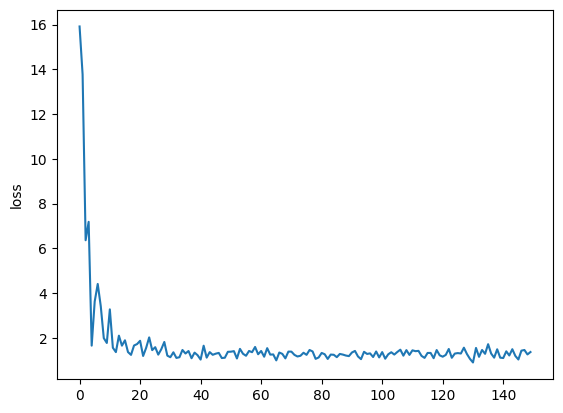

In [71]:
import matplotlib.pyplot as plt

plt.plot(metric_results)
plt.ylabel('loss')
plt.show()

#### eval trained policy

In [ ]:
tf.executing_eagerly()

In [ ]:
deployment_agent = agent.policy
deployment_agent

In [ ]:
# ====================================================
# Evaluate the agent's policy once after training
# ====================================================
print(f"evaluating trained Agent...")

post_policy_tf = py_tf_eager_policy.PyTFEagerPolicy(deployment_agent, use_tf_function=True)
start_time = time.time()

val_loss, preds, tr_rewards = _run_bandit_eval(
    policy = post_policy_tf,
    data = eval_ds,
    eval_batch_size = HPARAMS['eval_batch_size'],
    per_arm_dim = PER_ARM_DIM,
    global_dim = GLOBAL_DIM
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"post-train val_loss     : {val_loss}")
print(f"post-train eval runtime : {runtime_mins}")

## Using Trained Policy

### load trained policy

In [97]:
POLICY_URI = ARTIFACTS_DIR

print(POLICY_URI)

gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-231500/artifacts


In [98]:
!gsutil ls $POLICY_URI

gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-231500/artifacts/
gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-231500/artifacts/fingerprint.pb
gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-231500/artifacts/policy_specs.pbtxt
gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-231500/artifacts/saved_model.pb
gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-231500/artifacts/assets/
gs://mabv1-hybrid-vertex-bucket/mab-local-v6/run-20230821-231500/artifacts/variables/


In [99]:
from tf_agents.policies import py_tf_eager_policy

trained_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    POLICY_URI, load_specs_from_pbtxt=True
)

trained_policy

In [100]:
trained_policy.action_spec

BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action_spec', minimum=0, maximum=1)

In [87]:
INFER_SIZE = 1
dummy_arm = tf.zeros([INFER_SIZE, PER_ARM_DIM], dtype=tf.float32)

for x in eval_ds.take(INFER_SIZE):
    # get feature tensors
    global_feat_infer = _get_global_context_features(x)
    arm_feat_infer = _get_per_arm_features(x)
    rewards = _get_rewards(x)
    
    # reshape arm features
    arm_feat_infer = tf.reshape(arm_feat_infer, [HPARAMS['eval_batch_size'], PER_ARM_DIM]) # perarm_dim
    concat_arm = tf.concat([arm_feat_infer, dummy_arm], axis=0)
    
    # flatten global
    flat_global_infer = tf.reshape(global_feat_infer, [GLOBAL_DIM])
    feature = {'global': flat_global_infer, 'per_arm': concat_arm}
    
    # get actual reward
    actual_reward = rewards.numpy()[0]
    
    # build trajectory step
    trajectory_step = train_utils._get_eval_step(feature, actual_reward)
    
    prediction = trained_policy.action(trajectory_step)

### view prediction response

In [88]:
prediction

PolicyStep(action=array(0, dtype=int32), state=(), info=PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.400942, 3.400942], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=array([ 1.5639726e-02, -3.1821765e-02, -7.5147375e-03, -1.2750387e-02,
        4.9963664e-02, -3.3286057e-02,  2.0584855e-02,  4.2843375e-02,
        4.7787178e-02,  4.5679066e-02,  3.7793424e-02, -2.6883258e-02,
       -3.4554709e-02, -4.9798973e-03,  6.9301240e-03,  1.8555392e-02,
       -4.2709459e-02, -3.8219713e-02,  4.1822616e-02,  4.2918887e-02,
       -2.9764270e-02, -4.5768548e-02,  2.8009426e-02, -4.6644323e-03,
        4.1721944e-02,  3.5448086e-02,  4.0199231e-02,  3.8426746e-02,
       -7.5555667e-03, -2.7164925e-02, -2.0989180e-03, -4.8757769e-02,
        4.6904575e-02,  9.7514614e-03,  3.5535041e-02, -4.1110791e-02,
        1.9986000e-02, -4.6567429e-02, -3.

#### chosen action

In [89]:
prediction.action

array(0, dtype=int32)

#### Per Arm Policy Info

In [90]:
prediction.info

PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=array([3.400942, 3.400942], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=array([ 1.5639726e-02, -3.1821765e-02, -7.5147375e-03, -1.2750387e-02,
        4.9963664e-02, -3.3286057e-02,  2.0584855e-02,  4.2843375e-02,
        4.7787178e-02,  4.5679066e-02,  3.7793424e-02, -2.6883258e-02,
       -3.4554709e-02, -4.9798973e-03,  6.9301240e-03,  1.8555392e-02,
       -4.2709459e-02, -3.8219713e-02,  4.1822616e-02,  4.2918887e-02,
       -2.9764270e-02, -4.5768548e-02,  2.8009426e-02, -4.6644323e-03,
        4.1721944e-02,  3.5448086e-02,  4.0199231e-02,  3.8426746e-02,
       -7.5555667e-03, -2.7164925e-02, -2.0989180e-03, -4.8757769e-02,
        4.6904575e-02,  9.7514614e-03,  3.5535041e-02, -4.1110791e-02,
        1.9986000e-02, -4.6567429e-02, -3.9937124e-03,  1.7358091e-02,
        2.0064380e-02,  9.3

**Finished**